In [64]:
# IMPORTS
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy.linalg
import torch
import time
from tqdm import trange
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')

# PATH
import sys
sys.path.append('../../')
from sci.lib.loader import *
from sci.lib.recorder import * 
from sci.lib.utils import *


from sci.lib.vis.modes import *
from sci.lib.vis.post import *
from sci.lib.vis.reconstruct import *
from sci.lib.vis.data import *

# SETTINGS
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size':20})
DPI = 60

#GLOBALS
OUT_DIR = '../out/IPYNB/VIS'
VKS_DIR = '../data/VKS.pkl'
KPP_DIR = '../data/KPP.npz'
EE_DIR = '../data/EulerEqs.npz'
FIB_DIR = '../data/FiberData.dat'

## LOAD DATA

**VKS**

In [65]:
with open(VKS_DIR, 'rb') as f:
    vks = pickle.load(f)
vks = np.nan_to_num(vks)
print('Data Shape: {}'.format(vks.shape))

Data Shape: (505, 279, 400, 3)


**KPP**

In [66]:
npdata = np.load(KPP_DIR)
xv, yv, kpp = npdata['arr_0'], npdata['arr_1'], npdata['arr_2']
print('Data Shape: {}'.format(kpp.shape))

Data Shape: (20, 20, 501)


**EE**

In [67]:
npzdata = np.load(EE_DIR)
param = 50
rho, u, E, x, params, t = npzdata['arr_0'], npzdata['arr_1'], npzdata['arr_2'], npzdata['arr_3'], npzdata['arr_4'], npzdata['arr_5']
ee = np.array([rho[:,:,param], u[:,:,param], E[:,:,param]])
print('Data Shape: {}'.format(ee.shape))

Data Shape: (3, 500, 626)


# VKS Model

## Transient Data

In [68]:
s_ind = 0
e_ind = 400
shape = vks.shape
Nxy = shape[0]*shape[1]
pod_modes = 16
spatial_modes, data, eigenvalues, Ux_MS, Uy_MS = POD2(vks, s_ind, e_ind, pod_modes)
print("REDUCED MODEL SHAPE: {}".format(data.shape))

REDUCED MODEL SHAPE: (400, 16)


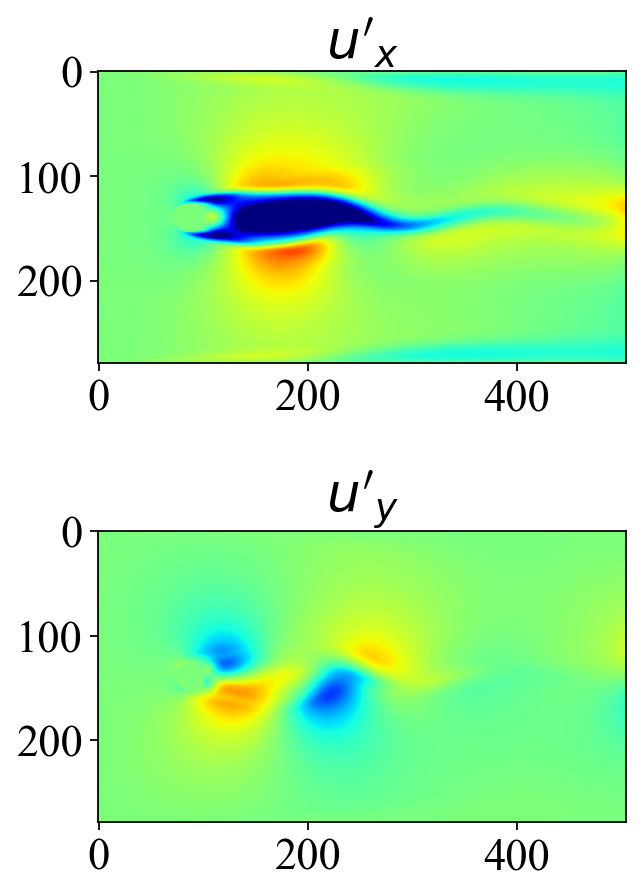

In [69]:
plt.figure(figsize=(10, 6), tight_layout=True, dpi=160)
plt.subplot(211)
plt.imshow(Ux_MS[50].T, cmap='jet', vmin=-.4, vmax=.4)
plt.title('$u\'_x$')

plt.subplot(212)
plt.imshow(Uy_MS[50].T, cmap='jet', vmin=-.4, vmax=.4)
plt.title('$u\'_y$')
plt.savefig('../out/VKS/transient.pdf', format='pdf', bbox_inches="tight")

## Non-Transient

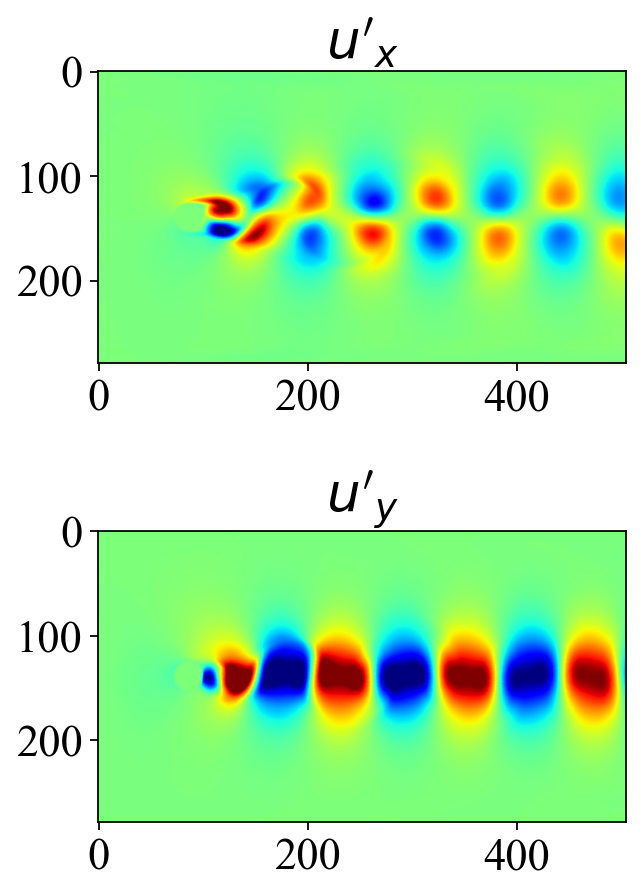

In [70]:
plt.figure(figsize=(10, 6), tight_layout=True, dpi=160)
plt.subplot(211)
plt.imshow(Ux_MS[150].T, cmap='jet', vmin=-.4, vmax=.4)
plt.title('$u\'_x$')

plt.subplot(212)
plt.imshow(Uy_MS[150].T, cmap='jet', vmin=-.4, vmax=.4)
plt.title('$u\'_y$')
plt.savefig('../out/VKS/non_transient.pdf', format='pdf', bbox_inches="tight")

# VKS Non-Transient

## Eigenvalue Decay

### DMD

Loading ... 	 Dataset: VKS
Reducing ... 	 Modes: 40
Decay value is 40 for 0.0015372876223409548 modes.


1

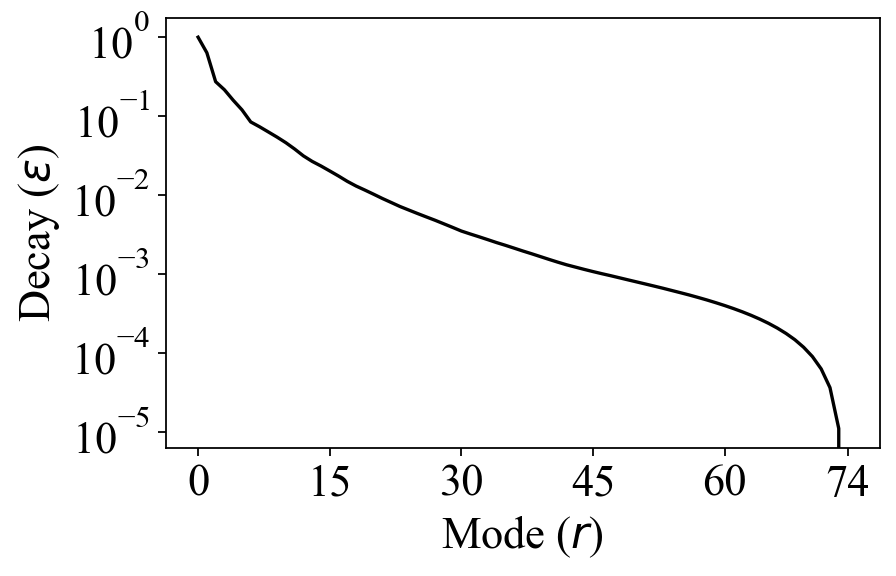

In [71]:
from sci.lib.dmd.parser import parse_args as dmd_parse
args_dmd = dmd_parse([])
args_dmd.tstart = 100
args_dmd.tstop = 175
args_dmd.tpred = 200
args_dmd.modes = 40
args_dmd.data_dir = VKS_DIR
args_dmd.out_dir = OUT_DIR+'/DMD/'
set_outdir(args_dmd.out_dir, args_dmd)

DL_DMD = DMD_LOADER(args_dmd)

eig_decay(DL_DMD,args_dmd)

### POD

Loading ... 	 Dataset: VKS
Reducing ... 	 Modes: 8
Decay value is 8 for 0.001193675008835271 modes.


1

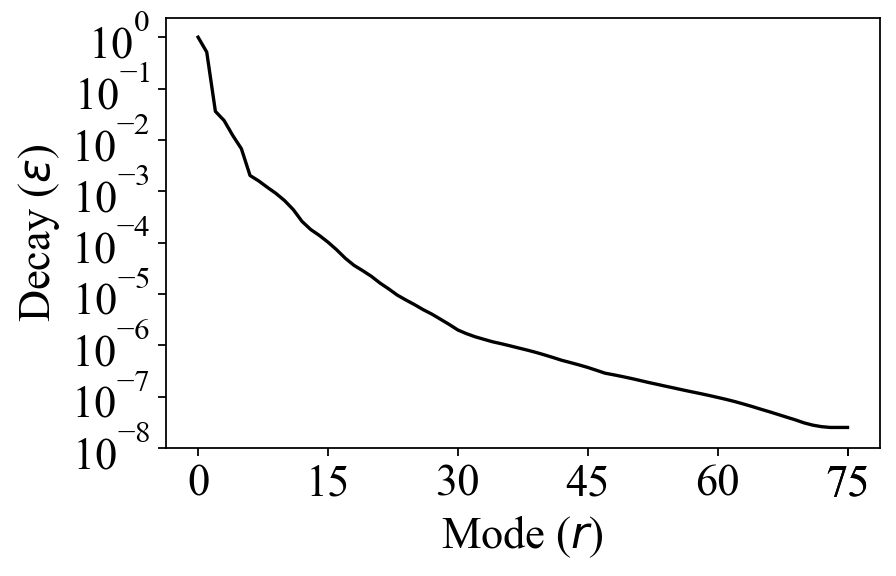

In [72]:
from sci.lib.vae.parser import parse_args as vae_parse
args_vae = vae_parse([])
args_vae.tstart = 100
args_vae.tstop = 175
args_vae.modes = 8
args_vae.data_dir = VKS_DIR
args_vae.out_dir = OUT_DIR+'/VAE/'
set_outdir(args_vae.out_dir, args_vae)

DL_VAE = STD_LOADER(args_vae)

eig_decay(DL_VAE,args_vae)

## Reconstruction


In [73]:
from sci.lib.vae.parser import parse_args as vae_parse
args_vae = vae_parse([])
args_vae.tstart = 100
args_vae.tstop = 200
args_vae.modes = 8
args_vae.data_dir = VKS_DIR
args_vae.out_dir = OUT_DIR+'/VAE/'
set_outdir(args_vae.out_dir, args_vae)

DL_VAE = STD_LOADER(args_vae)

Loading ... 	 Dataset: VKS
Reducing ... 	 Modes: 8



### FOM

In [74]:
modes = (DL_VAE.data-DL_VAE.mean_data)/DL_VAE.std_data
true = mode_to_true(DL_VAE,modes, args_vae)

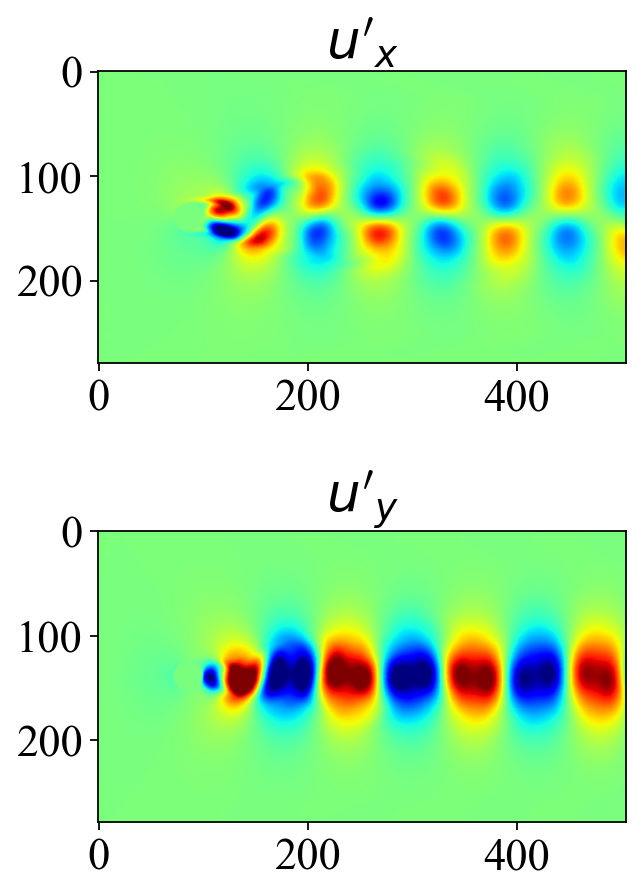

In [75]:

plt.figure(figsize=(10, 6), tight_layout=True, dpi=160)
plt.subplot(211)
plt.imshow(true[-1,:,:,0].T, cmap='jet', vmin=-.4, vmax=.4)
plt.title('$u\'_x$')

plt.subplot(212)
plt.imshow(true[-1,:,:,1].T, cmap='jet', vmin=-.4, vmax=.4)
plt.title('$u\'_y$')
plt.savefig('../out/VKS/rom_recon.pdf', format='pdf', bbox_inches="tight")

### DMD

In [76]:
args_dmd.tstart = 100
args_dmd.tstop = 175
args_dmd.tpred = 200
args_dmd.modes = 40
args_dmd.data_dir = VKS_DIR
args_dmd.out_dir = OUT_DIR+'/DMD/'
set_outdir(args_dmd.out_dir, args_dmd)

100%|██████████| 99/99 [00:11<00:00,  8.50it/s]


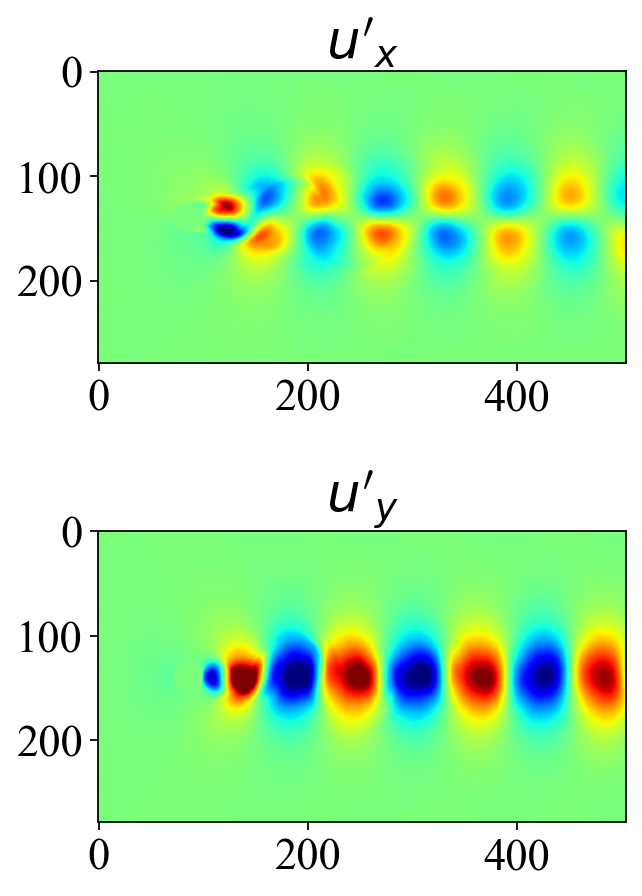

In [77]:
power =  args_dmd.tpred
Phi = DL_DMD.Phi
b = DL_DMD.b
Lambda = DL_DMD.Lambda

xr = Phi@Lambda@b

xk1 = xr[:Nxy].reshape(shape[0],shape[1])
xk2 = xr[Nxy:].reshape(shape[0],shape[1])

X = [[xk1.T,xk2.T]]

for k in trange(1,100):
    xr = np.real(Phi@(np.linalg.matrix_power(Lambda,k))@b)
    xk1 = xr[:Nxy].reshape(shape[0],shape[1])
    xk2 = xr[Nxy:].reshape(shape[0],shape[1])

    X = X + [[xk1.T,xk2.T]]
X = np.real(X).swapaxes(1,-1)


plt.figure(figsize=(10, 6), tight_layout=True, dpi=160)
plt.subplot(211)
plt.imshow(X[-1,:,:,0].T, cmap='jet', vmin=-.4, vmax=.4)
plt.title('$u\'_x$')

plt.subplot(212)
plt.imshow(X[-1,:,:,1].T, cmap='jet', vmin=-.4, vmax=.4)
plt.title('$u\'_y$')
plt.savefig('../out/VKS/DMD/data_recon.pdf', format='pdf', bbox_inches="tight")

### LSTM

In [78]:
class DataSet:

    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        """return length of the dataset"""

        return len(self.features)

    def __getitem__(self, idx):
        """ The PyTorch DataLoader class will use this method to
            make an iterable for training or validation loops """

        feature = self.features[idx]
        label = self.labels[idx]

        return feature, label

In [79]:
class LSTM(nn.Module):
    """ Encoder : transforms the input from data to latent
        space using a Seq2Vec architecture """

    def __init__(self, output_dim, input_dim, hidden_units, hidden_layers):

        super(LSTM, self).__init__()

        self.lstm = nn.LSTM(input_dim, hidden_units, hidden_layers, batch_first=True)

        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                nn.init.xavier_normal_(param)

        self.h2o = nn.Linear(hidden_units, output_dim)
        nn.init.xavier_uniform_(self.h2o.weight)

    def forward(self, x):

        y, _ = self.lstm(x)
        
        # take last step trough the dense layer
        y = y[:, -1, :]
        y = self.h2o(y)

        return y

In [80]:
import argparse
import torch.optim as optim
parser = argparse.ArgumentParser()
parser.add_argument('--nepochs', type=int, default=200)
parser.add_argument('--train_dir', type=str, default='./results/VKS_lstm')
args = parser.parse_args([])
s_ind = 100
e_ind = 300
pod_modes = 8
spatial_modes, data_ROM, eigenvalues, Ux_MS, Uy_MS = POD2(vks, s_ind, e_ind, pod_modes)

In [81]:

batch_size = 15
seq_window = 10
total_size = data_ROM.shape[0] - seq_window

# divide the data using the seq_window
data_ROM_s = np.vstack([[data_ROM[t:t + seq_window, :] for t in range(total_size)]])
label_data_ROM_s = data_ROM[seq_window:, :]

# window for the training
twindow = 75 - seq_window

# training data
data_ROM_t = data_ROM_s[:twindow, :, :]
mean = data_ROM_t.reshape((-1, data_ROM_t.shape[2])).mean(axis=0)
std = data_ROM_t.reshape((-1, data_ROM_t.shape[2])).std(axis=0)
data_ROM_t = (data_ROM_t - mean) / std

label_ROM_t = label_data_ROM_s[:twindow, :]
label_ROM_t = (label_ROM_t - mean) / std

train_data = DataSet(data_ROM_t, label_ROM_t)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)

# validation and evaluation data
validation_labels = torch.FloatTensor((data_ROM[twindow + seq_window:][:25, :] - mean) / std)
validation_features = torch.FloatTensor((data_ROM[twindow:][:seq_window, :] - mean) / std)
evaluation_labels = torch.FloatTensor(data_ROM[twindow + seq_window:])

results_folder = '../out/VKS/LSTM/'
set_outdir(results_folder, args_vae)


In [82]:
results_data = dict()

with open(results_folder + '/results_data.pth', 'wb') as f:
    pickle.dump(results_data, f)

# =============================================================================
'''                  Defining objects of the model                        '''
# =============================================================================

model = LSTM(pod_modes, pod_modes, 1, 49)

# =============================================================================
'''                       Training configurations                          '''
# =============================================================================

lr = .0081
optimizer = optim.AdamW(model.parameters(), lr, weight_decay=0.02)
criterion = torch.nn.MSELoss()

# number of iterations for the training
epochs = 500

# track change in validation loss
valid_loss_min = np.Inf

trLoss = []

# Training loop   
for epoch in trange(1, epochs + 1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    # train the model
    model.train()
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item() * data.size(0)

    # validate the model  
    model.eval()
    with torch.no_grad():

        predictions = []

        data = validation_features.unsqueeze(axis=0)

        for _ in range(validation_labels.shape[0]):
            # compute predicted outputs by passing inputs to the model
            output = model(data)
            predictions.append(output.detach().cpu().numpy())
            # autoregressive step
            data = torch.cat((data, output.unsqueeze(axis=0)), 1)[-seq_window:, :, :]

        output = torch.FloatTensor(predictions).squeeze()
        # calculate the batch loss
        valid_loss = criterion(output, validation_labels)

    # calculate average losses
    train_loss = train_loss / len(train_loader.sampler)
    trLoss = trLoss + [train_loss]

    # print training/validation statistics 
    #print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    #    epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        torch.save(model.state_dict(), results_folder+'model_lstm.pt')
        valid_loss_min = valid_loss

# load the best model
model.load_state_dict(torch.load(results_folder+'model_lstm.pt'))

# prep model for evaluation
model.eval()

# list to save predictions
predictions = []
# initial data for the autoregressive prediction
data = validation_features.unsqueeze(axis=0)

for _ in range(evaluation_labels.shape[0]):
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # save predictions
    predictions.append(output.detach().cpu().numpy())
    # autoregressive step      
    data = torch.cat((data, output.unsqueeze(axis=0)), 1)[-seq_window:, :, :]
    output = torch.FloatTensor(predictions).squeeze()

test = evaluation_labels.cpu().detach().numpy()
output_scaled = (output.cpu().detach().numpy()*std + mean)

# save predictions
with open(results_folder+'/data_lstm8.pth', 'wb') as f:
    pickle.dump(output_scaled[25:], f)

100%|██████████| 500/500 [10:48<00:00,  1.30s/it]


In [83]:
file_lstm = open(results_folder+'data_lstm8.pth', "rb")

predictions_LSTM = pickle.load(file_lstm).squeeze()

In [84]:
vks_lstm = np.matmul(predictions_LSTM, spatial_modes.T)

pod_x = vks_lstm[:, :DL_VAE.Nxy]
pod_y = vks_lstm[:, DL_VAE.Nxy:]

shape = [vks_lstm.shape[0], DL_VAE.data_init.shape[0], DL_VAE.data_init.shape[1]]
true_x = pod_x.reshape(pod_x.shape[0], shape[1], shape[2])
true_x = true_x.swapaxes(0,-1)
true_y = pod_y.reshape(pod_y.shape[0], shape[1], shape[2])
true_y = true_y.swapaxes(0,-1)

vks_lstm = np.array([true_x,true_y]).T

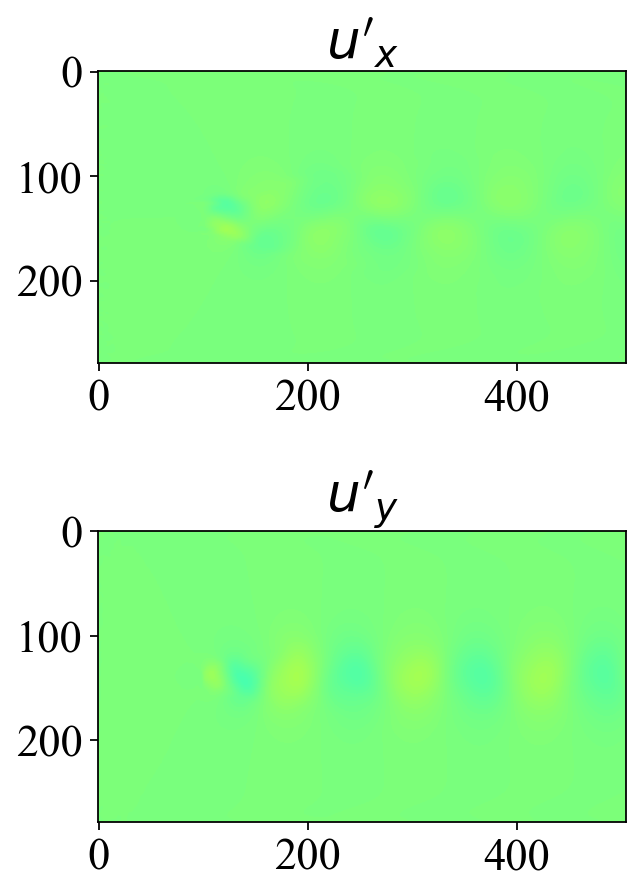

In [85]:
plt.figure(figsize=(10, 6), tight_layout=True, dpi=160)
plt.subplot(211)
plt.imshow(vks_lstm[-1,:,:,0].T, cmap='jet', vmin=-.4, vmax=.4)
plt.title('$u\'_x$')

plt.subplot(212)
plt.imshow(vks_lstm[-1,:,:,1].T, cmap='jet', vmin=-.4, vmax=.4)
plt.title('$u\'_y$')
plt.savefig('../out/VKS/DMD/data_recon.pdf', format='pdf', bbox_inches="tight")

### NODE

In [86]:
from sci.lib.vae.models import *
from sci.lib.vae.parser import parse_args as vae_parse
args_vae = vae_parse([])
args_vae.data_dir = VKS_DIR
args_vae.out_dir = OUT_DIR+'/VAE/'
set_outdir(args_vae.out_dir, args_vae)
args = args_vae

In [87]:
DL = STD_LOADER(args)
obs_dim = DL.train_data.shape[2]
latent_dim = obs_dim - args.latent_dim
layers_node = [latent_dim] + args.layers_node + [latent_dim]

MODELS = {'NODE' : NODE(df = LatentODE(layers_node)),
        'HBNODE' : hbnode(LatentODE(layers_node))}

if args.model == "HBNODE":
    latent_dim = latent_dim*2
#NETWORKS
enc = Encoder(latent_dim, obs_dim, args.units_enc, args.layers_enc)
node = MODELS[args.model]
dec = Decoder(latent_dim, obs_dim, args.units_dec, args.layers_dec)
params = (list(enc.parameters()) + list(node.parameters()) + list(dec.parameters()))

#LEARNING UTILITIES
optimizer = optim.AdamW(params, lr= args.lr)
loss_meter_t = RunningAverageMeter()
meter_train = RunningAverageMeter()
meter_valid = RunningAverageMeter()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                factor=args.factor, patience=5, verbose=False, threshold=1e-5,
                                                threshold_mode='rel', cooldown=0, min_lr=1e-7, eps=1e-08)
criterion = torch.nn.MSELoss()
lossTrain = []
lossVal = []

Loading ... 	 Dataset: VKS
Reducing ... 	 Modes: 8


In [90]:
for itr in trange(1, args.epochs + 1):

    optimizer.zero_grad()

    #SCHEDULE
    for param_group in optimizer.param_groups:
        current_lr = param_group['lr']
    scheduler.step(metrics=loss_meter_t.avg)

    #FORWARD STEP
    out_enc = enc.forward(DL.obs_t)
    qz0_mean, qz0_logvar = out_enc[:, :latent_dim], out_enc[:, latent_dim:]
    epsilon = torch.randn(qz0_mean.size())
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
    zt = odeint(node, z0, DL.train_times, method='rk4').permute(1, 0, 2)
    output_vae_t = dec(zt)

    # LOSS
    pz0_mean = pz0_logvar = torch.zeros(z0.size())
    analytic_kl = normal_kl(qz0_mean, qz0_logvar,
                            pz0_mean, pz0_logvar).sum(-1)
    kl_loss = torch.mean(analytic_kl, dim=0)
    loss = criterion(output_vae_t, DL.train_data) + kl_loss

    #BACK PROP
    loss.backward()
    optimizer.step()
    loss_meter_t.update(loss.item())
    meter_train.update(loss.item() - kl_loss.item())
    lossTrain.append(meter_train.avg)

    #VALIDATION
    with torch.no_grad():

        enc.eval()
        node.eval()
        dec.eval()

        zv = odeint(node, z0, DL.valid_times, method='rk4').permute(1, 0, 2)
        output_vae_v = dec(zv)

        loss_v = criterion(output_vae_v[:, DL.tr_ind:],
                            DL.valid_data[:, DL.tr_ind:])

        meter_valid.update(loss_v.item())
        lossVal.append(meter_valid.avg)

        enc.train()
        node.train()
        dec.train()

    #OUTPUT
    if itr % args.epochs == 0:
        output_vae = output_vae_v.cpu().detach().numpy()*DL.std_data+DL.mean_data

    if np.isnan(lossTrain[itr - 1]):
        break


#SAVE MODEL DATA
torch.save(enc.state_dict(), args.out_dir + './pth/enc.pth')
torch.save(node.state_dict(), args.out_dir + './pth/node.pth')
torch.save(dec.state_dict(), args.out_dir + './pth/dec.pth')

#FORWARD STEP TEST DATA
with torch.no_grad():

    enc.eval()
    node.eval()
    dec.eval()

    ze = odeint(node, z0, DL.eval_times, method='rk4').permute(1, 0, 2)
    output_vae_e = dec(ze)

    enc.train()
    node.train()
    dec.train()

    #SAVE TEST DATA
    data_NODE = (output_vae_e.cpu().detach().numpy()) * DL.std_data + DL.mean_data
    with open(results_folder+'data_node8.pth', 'wb') as f:
        pickle.dump(data_NODE, f)

100%|██████████| 500/500 [02:22<00:00,  3.52it/s]


In [91]:
file_node = open(results_folder+'data_node8.pth', "rb")

predictions_NODE = pickle.load(file_node).squeeze()

In [92]:
vks_node = np.matmul(predictions_NODE, spatial_modes.T)

pod_x = vks_node[:, :DL_VAE.Nxy]
pod_y = vks_node[:, DL_VAE.Nxy:]

shape = [vks_node.shape[0], DL_VAE.data_init.shape[0], DL_VAE.data_init.shape[1]]
true_x = pod_x.reshape(pod_x.shape[0], shape[1], shape[2])
true_x = true_x.swapaxes(0,-1)
true_y = pod_y.reshape(pod_y.shape[0], shape[1], shape[2])
true_y = true_y.swapaxes(0,-1)

vks_node = np.array([true_x,true_y]).T

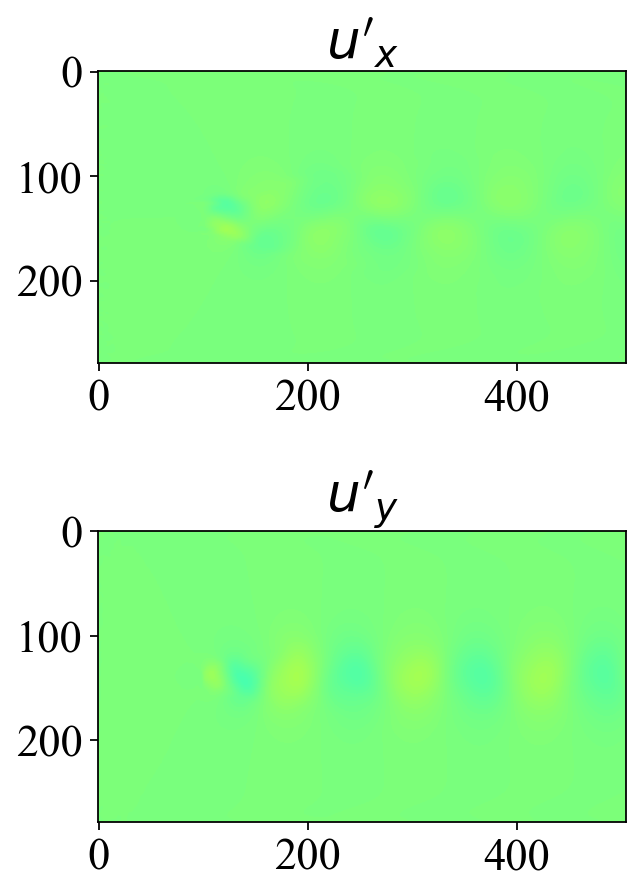

In [93]:
plt.figure(figsize=(10, 6), tight_layout=True, dpi=160)
plt.subplot(211)
plt.imshow(vks_lstm[-1,:,:,0].T, cmap='jet', vmin=-.4, vmax=.4)
plt.title('$u\'_x$')

plt.subplot(212)
plt.imshow(vks_lstm[-1,:,:,1].T, cmap='jet', vmin=-.4, vmax=.4)
plt.title('$u\'_y$')
plt.savefig('../out/VKS/DMD/data_recon.pdf', format='pdf', bbox_inches="tight")

# VKS Transient

# KPP Experiments

Loading ... 	 Dataset: KPP
Reducing ... 	 Modes: 16


1

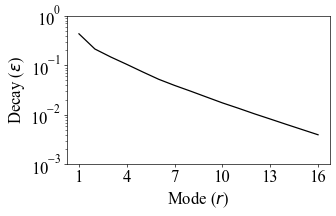

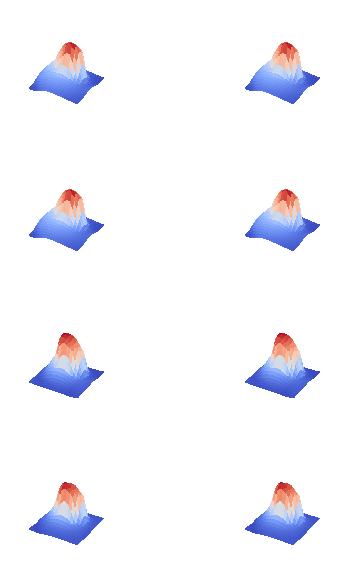

In [17]:
from sci.lib.dmd.parser import parse_args as dmd_parse
args = dmd_parse([])
args.tstart = 0
args.data_dir = KPP_DIR
args.dataset = 'KPP'
args.out_dir = OUT_DIR+'/VAE/'
set_outdir(args.out_dir, args)

DL = DMD_LOADER(args)

eig_decay(DL,args)
data_modes(DL,args)

### EE

In [121]:
npzdata = np.load(EE_DIR)
param = 50
param2 = 45
rho, u, E, x, params, t = npzdata['arr_0'], npzdata['arr_1'], npzdata['arr_2'], npzdata['arr_3'], npzdata['arr_4'], npzdata['arr_5']
ee = np.array([rho[:,:,param], u[:,:,param], E[:,:,param]])
ee2 = np.array([rho[:,:,param2], u[:,:,param2], E[:,:,param2]])
shape = ee.shape
print('Data Shape: {}'.format(ee.shape))

Data Shape: (3, 500, 626)


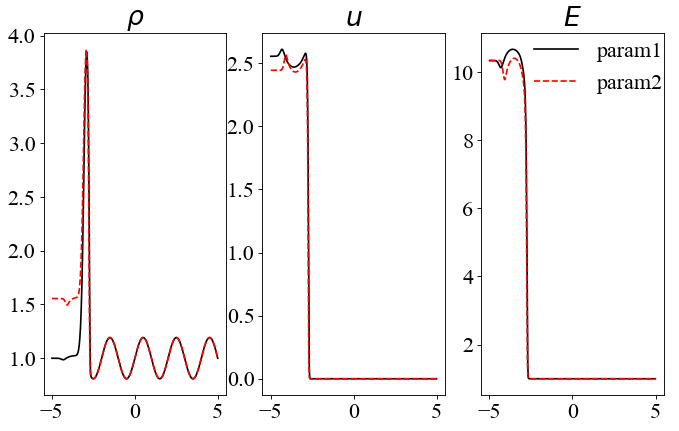

In [122]:
plt.figure(figsize=(10, 6), dpi=80)
plt.subplot(131)
plt.plot(x, ee[0,:,45], 'k')
plt.plot(x, ee2[0,:,45], 'r--')
plt.title('$\\rho$')

plt.subplot(132)
plt.plot(x, ee[1,:,45], 'k')
plt.plot(x, ee2[1,:,45], 'r--')
plt.title('$u$')

plt.subplot(133)
plt.plot(x, ee[2,:,45], 'k', label='param1')
plt.plot(x, ee2[2,:,45], 'r--', label='param2')
plt.title('$E$')

plt.legend(bbox_to_anchor=(.24, 1), loc='upper left', borderaxespad=0, ncol=1, frameon=False)
plt.savefig('../out/EE/param.pdf', format='pdf', bbox_inches="tight")
plt.show()

Loading ... 	 Dataset: EE
Reducing ... 	 Modes: 16


1

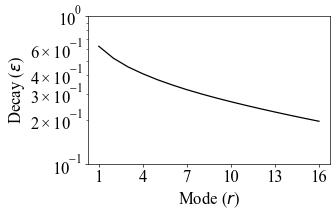

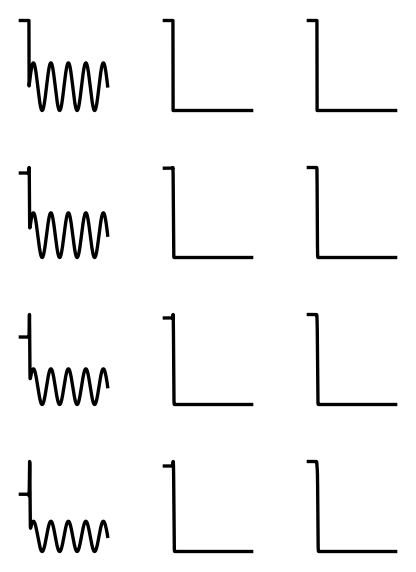

In [18]:
from sci.lib.dmd.parser import parse_args as dmd_parse
args = dmd_parse([])
args.tstart = 0
args.data_dir = EE_DIR
args.dataset = 'EE'
args.out_dir = OUT_DIR+'/VAE/'
set_outdir(args.out_dir, args)

DL = DMD_LOADER(args)

eig_decay(DL,args)
data_modes(DL,args)

## DATA POD MODES

Loading ... 	 Dataset: VKS
Reducing ... 	 Modes: 8


1

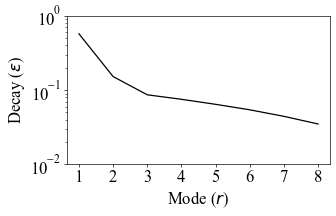

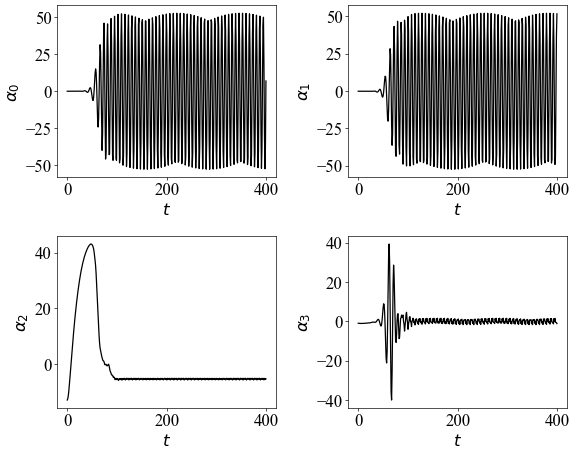

In [32]:
from sci.lib.seq.parser import parse_args as seq_parse
args = seq_parse([])
args.modes = 8
args.tstart = 0
args.data_dir = VKS_DIR
args.out_dir = OUT_DIR+'/VAE/'
set_outdir(args.out_dir, args)
DL = SEQ_LOADER(args)

eig_decay(DL,args)
data_modes(DL,args)

Loading ... 	 Dataset: KPP
Reducing ... 	 Modes: 8


1

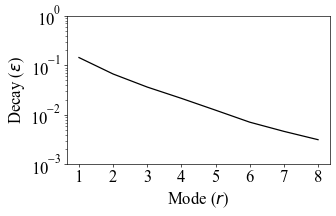

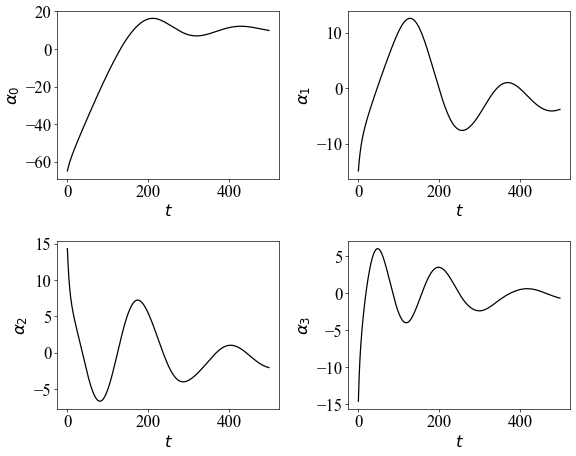

In [33]:
from sci.lib.seq.parser import parse_args as seq_parse
args = seq_parse([])
args.modes = 8
args.tstart = 0
args.data_dir = KPP_DIR
args.dataset = 'KPP'
args.out_dir = OUT_DIR+'/VAE/'
set_outdir(args.out_dir, args)
DL = SEQ_LOADER(args)

eig_decay(DL,args)
data_modes(DL,args)

Loading ... 	 Dataset: EE
Reducing ... 	 Modes: 8


1

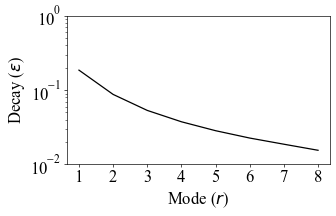

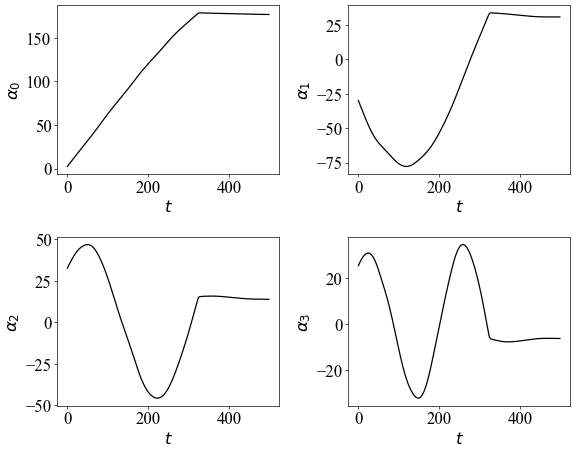

In [34]:
from sci.lib.seq.parser import parse_args as seq_parse
args = seq_parse([])
args.modes = 8
args.tstart = 0
args.data_dir = EE_DIR
args.dataset = 'EE'
args.out_dir = OUT_DIR+'/VAE/'
set_outdir(args.out_dir, args)
DL = SEQ_LOADER(args)

eig_decay(DL,args)
data_modes(DL,args)

## DATA ANIMATIONS

Loading ... 	 Dataset: VKS
Reducing ... 	 Modes: 8


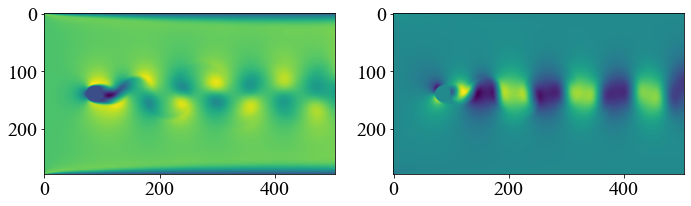

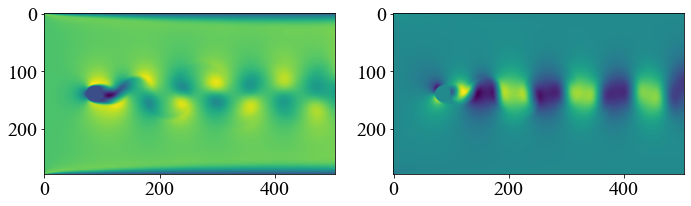

In [35]:
from sci.lib.seq.parser import parse_args as seq_parse
args = seq_parse([])
args.modes = 8
args.tstart = 0
args.data_dir = VKS_DIR
args.out_dir = OUT_DIR+'/VAE/'
set_outdir(args.out_dir, args)

DL = SEQ_LOADER(args)

data = np.moveaxis(DL.data_init,2,0)
data_reconstruct(data,100,args)

Loading ... 	 Dataset: KPP
Reducing ... 	 Modes: 8


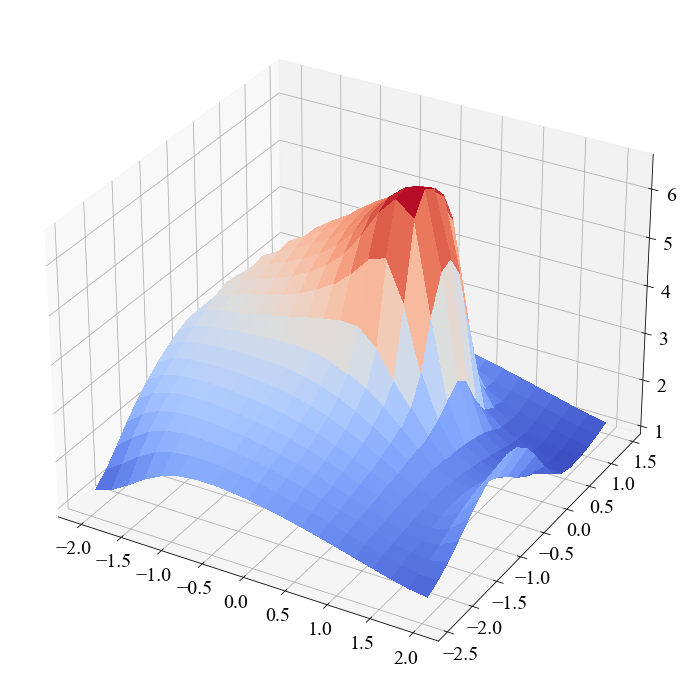

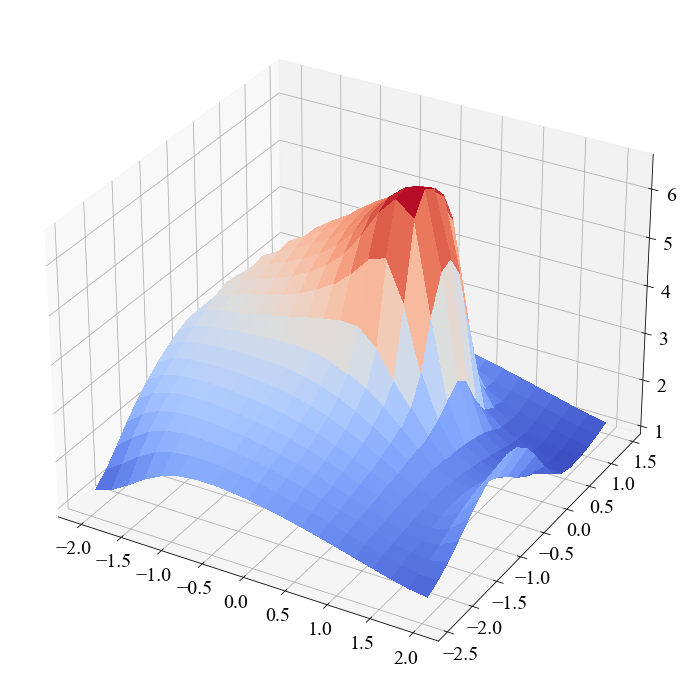

In [36]:
from sci.lib.seq.parser import parse_args as seq_parse
args = seq_parse([])
args.modes = 8
args.tstart = 0
args.data_dir = KPP_DIR
args.dataset = 'KPP'
args.out_dir = OUT_DIR+'/VAE/'
set_outdir(args.out_dir, args)

DL = SEQ_LOADER(args)

data_reconstruct(DL.data_init,100,args)

Loading ... 	 Dataset: EE
Reducing ... 	 Modes: 8


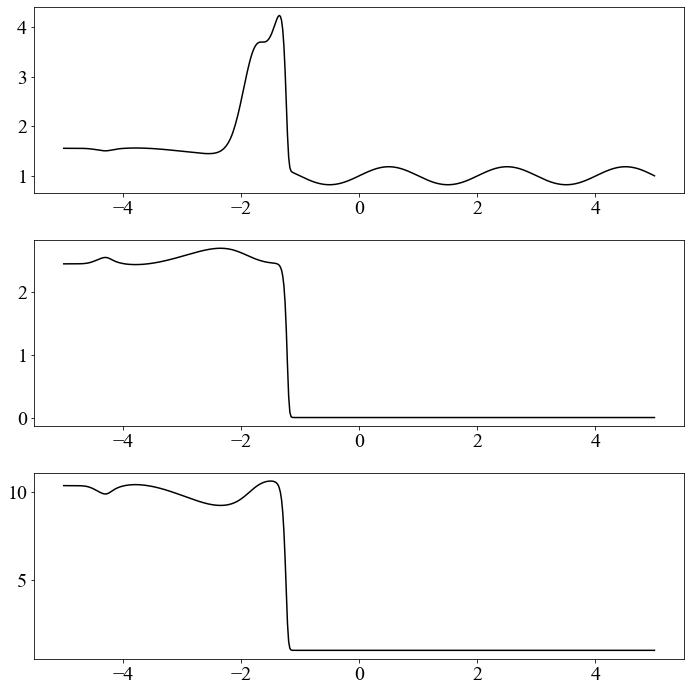

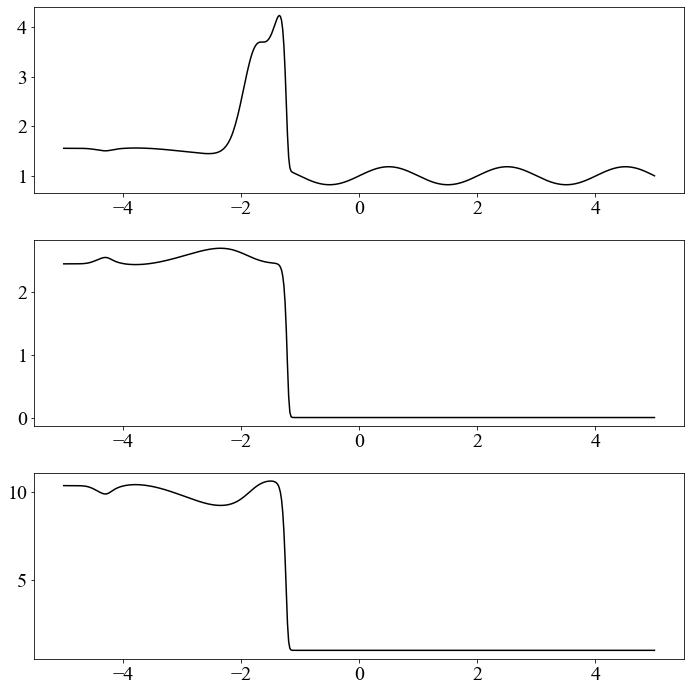

In [37]:
from sci.lib.seq.parser import parse_args as seq_parse
args = seq_parse([])
args.modes = 8
args.tstart = 0
args.data_dir = EE_DIR
args.dataset = 'EE'
args.out_dir = OUT_DIR+'/VAE/'
set_outdir(args.out_dir, args)

DL = SEQ_LOADER(args)

data_reconstruct(DL.data_init,100,args)

## Standard Data

In [ ]:
from sci.lib.vae.parser import parse_args as vae_parse
args = vae_parse([])
args.data_dir = KPP_DIR
args.dataset='KPP'
args.out_dir = OUT_DIR+'/VAE/'
set_outdir(args.out_dir, args)
DL = STD_LOADER(args)

Loading ... 	 Dataset: KPP
Reducing ... 	 Modes: 8


### Eigen Value Decay

1

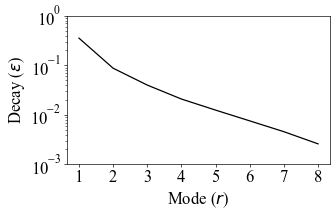

In [ ]:
eig_decay(DL,args)

1

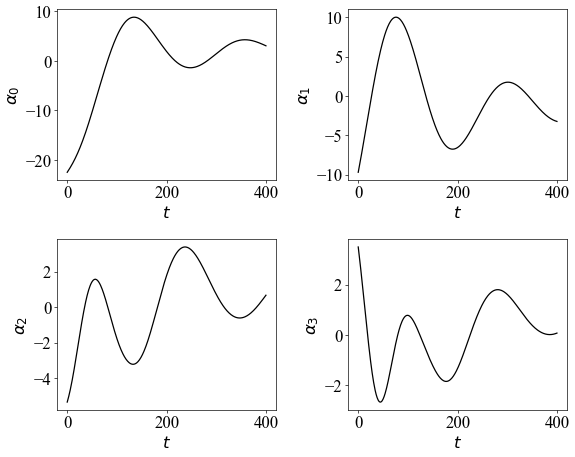

In [ ]:
data_modes(DL,args)

(20, 20, 501)


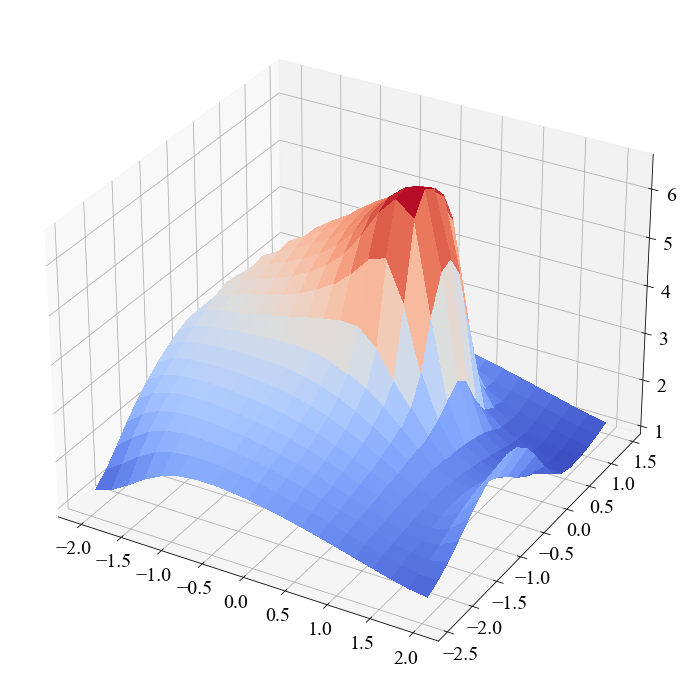

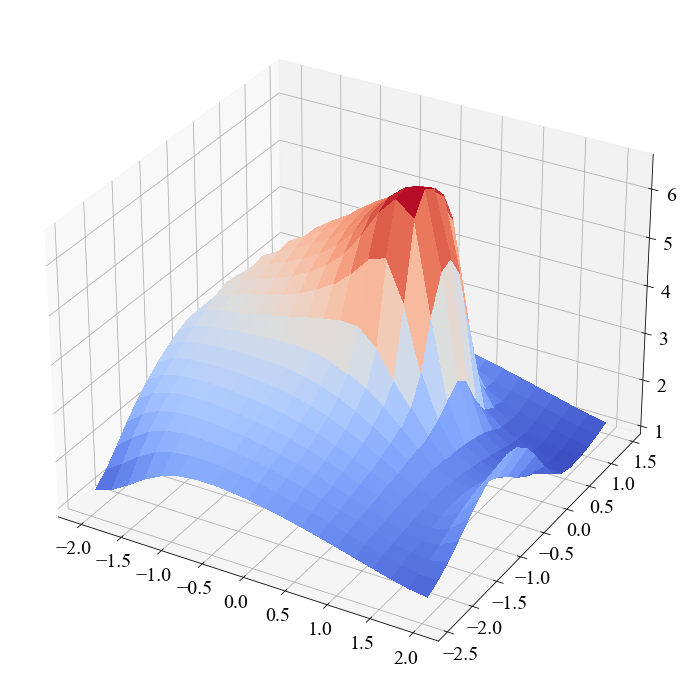

In [ ]:
# data = np.moveaxis(DL.data_init,2,0)
print(DL.data_init.shape)
data_reconstruct(DL.data_init,100,args)

In [ ]:
print(DL.data_init.shape)

(20, 20, 501)


MovieWriter PillowWriter unavailable; using Pillow instead.


1

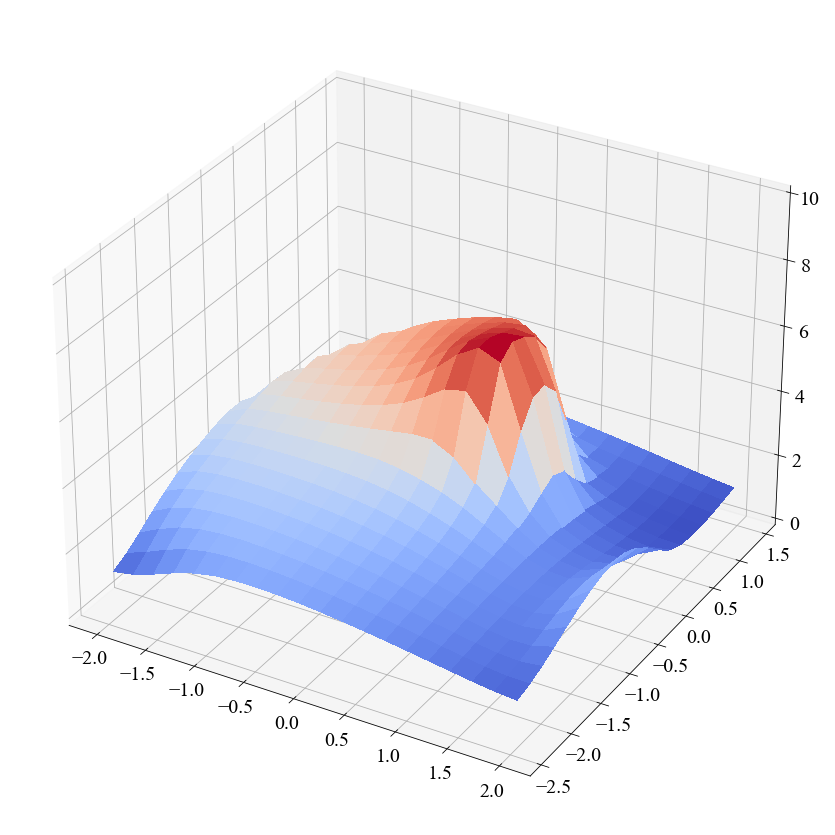

In [ ]:
data_animation(DL.data_init,args)

## Sequence Data

In [21]:
from sci.lib.seq.parser import parse_args as seq_parse
args = seq_parse([])
args.modes = 8
args.tstart = 0
args.data_dir = VKS_DIR
args.out_dir = OUT_DIR+'/VAE/'
set_outdir(args.out_dir, args)
DL = SEQ_LOADER(args)

Loading ... 	 Dataset: VKS
Reducing ... 	 Modes: 8


1

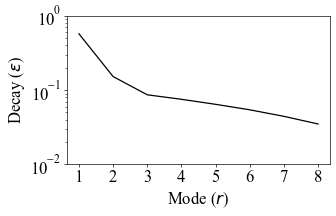

In [22]:
eig_decay(DL,args)

1

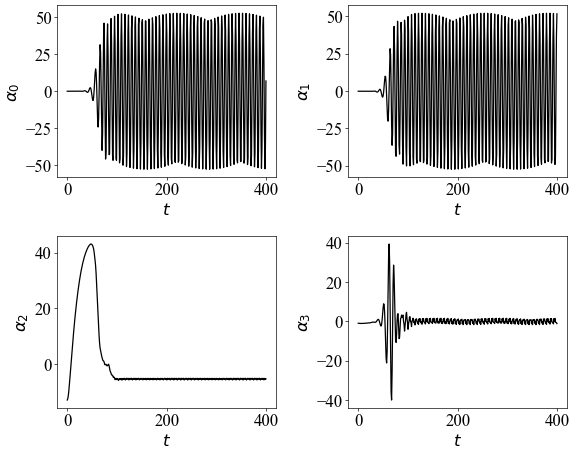

In [23]:
data_modes(DL,args)

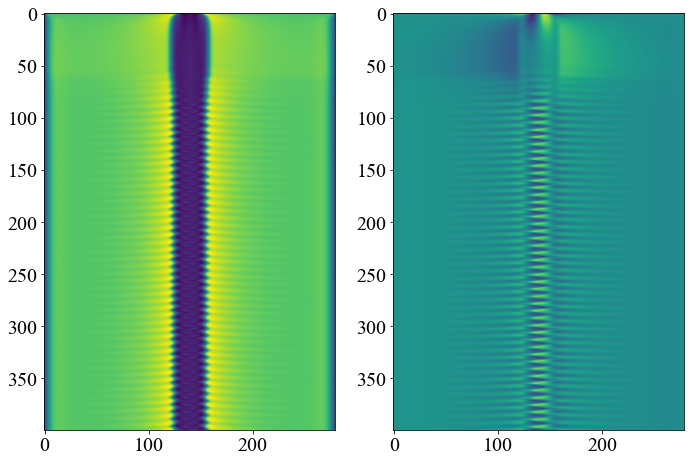

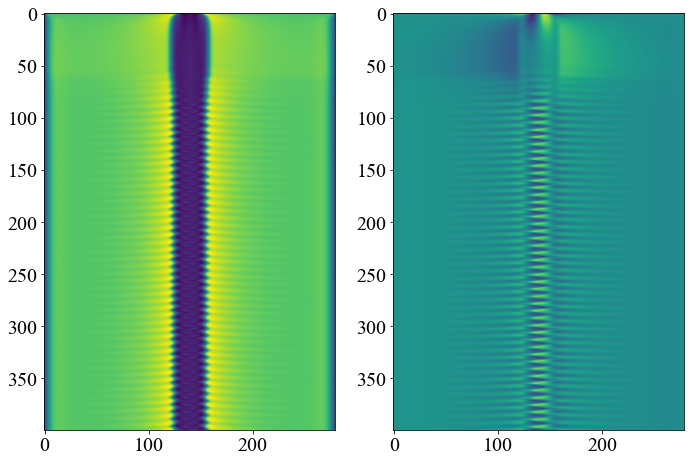

In [24]:
data_reconstruct(DL.data_init,100,args)

MovieWriter PillowWriter unavailable; using Pillow instead.


1

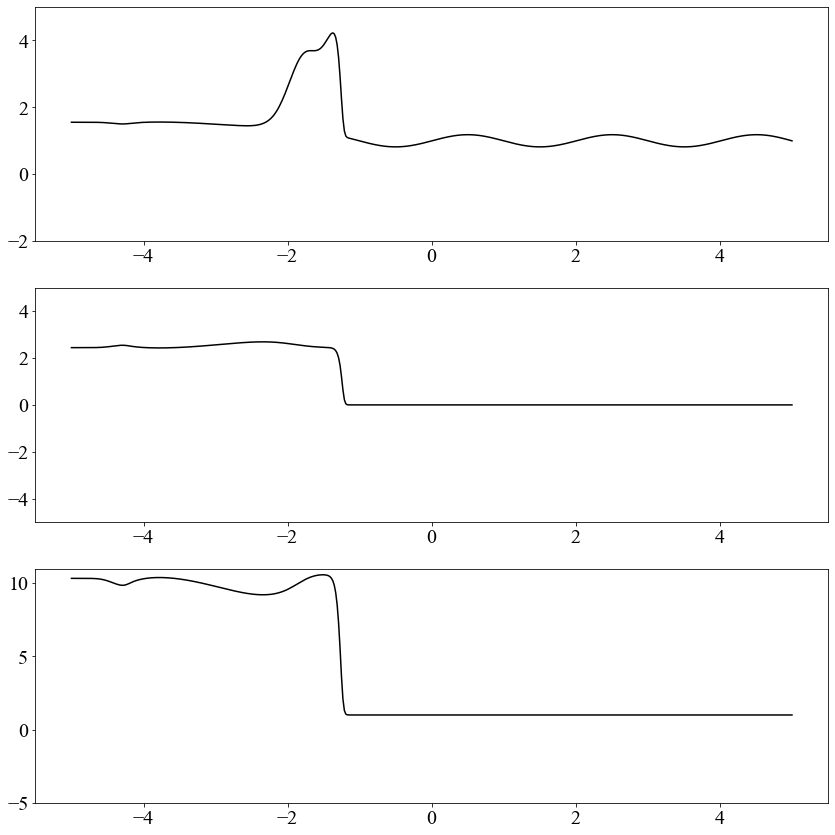

In [ ]:
data_animation(DL.data_init,args)